<a href="https://colab.research.google.com/github/piyush-an/INFO7374_Predict_StockPrice/blob/main/notebooks/3_Feat_Importance_RegVsTrees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part - 3: Visualize the feature importance and feature selection process
- Regression based approach, such as Ridge regression, LASSO, Elastic Net or LARS

    `vs`

- Decision tree based approach (random forest, XGBoost)

## Importing libraries

In [ ]:
%%bash

pip install pandas yfinance ta seaborn matplotlib pandas-datareader jinja2 fredapi openpyxl xgboost scikit-learn statsmodels mlflow


In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
from sklearn import linear_model
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import math
import xgboost as xgb
from xgboost import XGBRegressor
import math

pd.set_option('display.max_columns', None)
plt.rcParams["figure.figsize"] = (15, 20)

In [2]:
import mlflow
from mlflow.entities import ViewType
from mlflow.tracking import MlflowClient

MLFLOW_TRACKING_URI = "http://mlflow.anandpiyush.com"
SET_EXPERIMENT = "info7374_nvdia_model_v2"
EXPERIMENT_ID = "3"

mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment(SET_EXPERIMENT)
client = MlflowClient(tracking_uri=MLFLOW_TRACKING_URI)
mlflow.sklearn.autolog(silent=True)
mlflow.xgboost.autolog(silent=True)

Define start and end dates. Frequency is daily.

In [8]:
# Define dataset start and end date
start_date = datetime(2020, 1, 1)
end_date = datetime(2023, 12, 31)


# Downloaded data
# NVDA_STOCK = yf.download("NVDA", start_date, end_date)

# NVDA_STOCK.describe()

Calculating daily returns:

## Data Set Split

In [3]:
nvda = pd.read_csv("https://raw.githubusercontent.com/piyush-an/INFO7374_Predict_StockPrice/main/notebooks/NVDA_feature_mart.csv")
nvda.set_index("Unnamed: 0", inplace=True)

# nvda = nvda.drop(["Adj Close"], axis=1)
# columns_to_keep = ['Open', 'Close', 'High', 'Low', 'Typical_Price', 'Momentum_KAMA', 'Trend_EMA', 'Volumne_VWAP', 'Volatility_ATR', 'Volatility_KeltnerChannel', 'SP500']
# nvda = nvda[columns_to_keep]
# nvda.head()

nvda.index = pd.to_datetime(nvda.index)
nvda = nvda[nvda.index >= pd.to_datetime('2022-01-01')]
split_date = pd.to_datetime('2023-07-31')

df_train = nvda[nvda.index <= split_date]
df_test = nvda[nvda.index > split_date]

print(f"Number of rows in df_train: {len(df_train)}")
print(f"Number of rows in df_test: {len(df_test)}")

columns_to_keep = []
columns_to_drop = ["Open", "High", "Low", "Typical_Price"]

X_train = df_train.loc[:, df_train.columns != "Close"][:-1]
X_train = X_train.drop(columns_to_drop, axis=1)
y_train = df_train["Close"].shift(-1)[:-1]

X_test = df_test.loc[:, df_test.columns != "Close"][:-1]
X_test = X_test.drop(columns_to_drop, axis=1)
y_test = df_test["Close"].shift(-1)[:-1]

Number of rows in df_train: 393
Number of rows in df_test: 64


## Random Forest Regressors

In [4]:
from itertools import product

# Define the hyperparameters to tune
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_leaf': [1, 2, 4]
}

# Loop through all combinations of hyperparameters
for n_estimators in param_grid['n_estimators']:
    for max_depth in param_grid['max_depth']:
        for min_samples_leaf in param_grid['min_samples_leaf']:
            with mlflow.start_run():
                # Create the model with specific parameters
                model = RandomForestRegressor(n_estimators=n_estimators,
                                              max_depth=max_depth,
                                              min_samples_leaf=min_samples_leaf)

                # Fit the model and make predictions
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)

                # Calculate RMSE
                MSE = mean_squared_error(y_test, y_pred, squared=False)
                RMSE = math.sqrt(MSE)

                # Log metrics and parameters to MLflow
                mlflow.set_tag("model", "RandomForestRegressor")
                mlflow.log_metric("RMSE", RMSE)

                print(f"RandomForestRegressor - RMSE: {RMSE:.2f}")


RandomForestRegressor - RMSE: 4.73
RandomForestRegressor - RMSE: 4.66
RandomForestRegressor - RMSE: 4.99
RandomForestRegressor - RMSE: 4.87
RandomForestRegressor - RMSE: 4.86
RandomForestRegressor - RMSE: 4.45
RandomForestRegressor - RMSE: 5.32
RandomForestRegressor - RMSE: 5.45
RandomForestRegressor - RMSE: 4.59
RandomForestRegressor - RMSE: 4.87
RandomForestRegressor - RMSE: 5.16
RandomForestRegressor - RMSE: 4.86
RandomForestRegressor - RMSE: 4.79
RandomForestRegressor - RMSE: 4.74
RandomForestRegressor - RMSE: 4.85
RandomForestRegressor - RMSE: 4.84
RandomForestRegressor - RMSE: 4.70
RandomForestRegressor - RMSE: 5.16
RandomForestRegressor - RMSE: 4.86
RandomForestRegressor - RMSE: 4.77
RandomForestRegressor - RMSE: 4.85
RandomForestRegressor - RMSE: 4.64
RandomForestRegressor - RMSE: 4.73
RandomForestRegressor - RMSE: 4.90
RandomForestRegressor - RMSE: 4.97
RandomForestRegressor - RMSE: 4.76
RandomForestRegressor - RMSE: 4.87


### Retrive the best model


In [5]:
best_run_id = runs = client.search_runs(
        experiment_ids=EXPERIMENT_ID,
        run_view_type=ViewType.ACTIVE_ONLY,
        max_results=1,
        order_by=["metrics.RMSE ASC"],
        filter_string="tags.model = 'RandomForestRegressor'"
    )[0].info.run_id

loaded_model = mlflow.pyfunc.load_model(f"runs:/{best_run_id}/model")
y_pred = loaded_model.predict(X_test)

MSE = mean_squared_error(y_test, y_pred, squared=False)
RMSE = math.sqrt(MSE)

print(f"RandomForestRegressor - RMSE: {RMSE}")

RandomForestRegressor - RMSE: 4.452209360647558


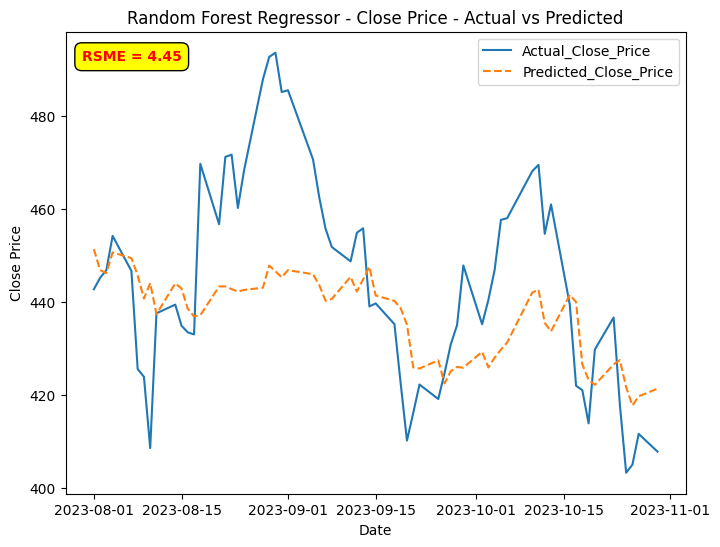

In [6]:
plt.figure(figsize=(8, 6))
plt.plot(y_test, label='Actual_Close_Price', linestyle='solid')
plt.plot(pd.Series(y_pred, index=y_test.index), label='Predicted_Close_Price', linestyle='dashed')
plt.title('Random Forest Regressor - Close Price - Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.figtext(0.27, .85, f"RSME = {RMSE:.2f}", ha='right', va='top', color='red', weight='bold', bbox=dict(facecolor='yellow', edgecolor='black', boxstyle='round,pad=0.5'))
plt.show()

## Ridge Regression

In [8]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

alphas = [0.1, 0.5, 1.0, 5.0, 10.0]

for alpha in alphas:
    with mlflow.start_run():
        ridge = Ridge(alpha=alpha)
        ridge.fit(X_train_scaled, y_train)

        y_pred = ridge.predict(X_test_scaled)
        MSE = mean_squared_error(y_test, y_pred, squared=False)
        RMSE = math.sqrt(MSE)

        mlflow.set_tag("model", "Ridge")
        mlflow.log_metric("RMSE", RMSE)

        print(f"Ridge - RMSE: {RMSE:.2f}")

Ridge - RMSE: 3.42
Ridge - RMSE: 3.49
Ridge - RMSE: 3.54
Ridge - RMSE: 3.72
Ridge - RMSE: 3.96


In [14]:
best_run_id = runs = client.search_runs(
        experiment_ids=EXPERIMENT_ID,
        run_view_type=ViewType.ACTIVE_ONLY,
        max_results=1,
        order_by=["metrics.RMSE ASC"],
        filter_string="tags.model = 'Ridge'"
    )[0].info.run_id

loaded_model = mlflow.pyfunc.load_model(f"runs:/{best_run_id}/model")
y_pred = loaded_model.predict(X_test_scaled)

MSE = mean_squared_error(y_test, y_pred, squared=False)
RMSE = math.sqrt(MSE)

print(f"Ridge - RMSE: {RMSE}")

Ridge - RMSE: 3.419473795239898


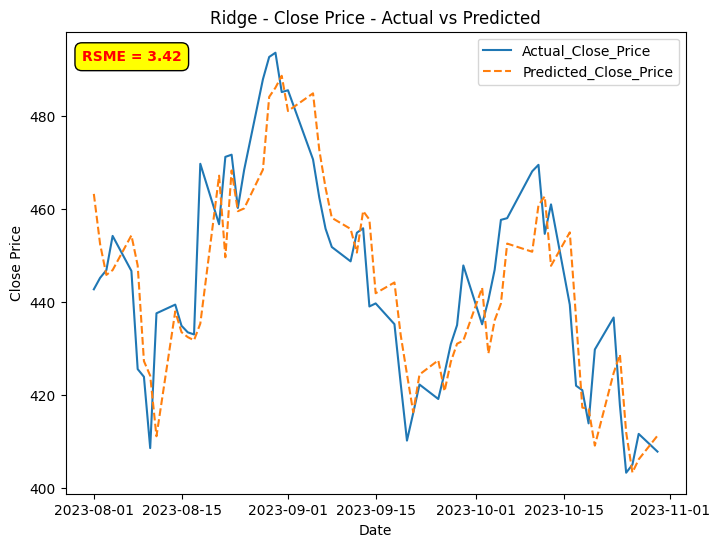

In [15]:
plt.figure(figsize=(8, 6))
plt.plot(y_test, label='Actual_Close_Price', linestyle='solid')
plt.plot(pd.Series(y_pred, index=y_test.index), label='Predicted_Close_Price', linestyle='dashed')
plt.title('Ridge - Close Price - Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.figtext(0.27, .85, f"RSME = {RMSE:.2f}", ha='right', va='top', color='red', weight='bold', bbox=dict(facecolor='yellow', edgecolor='black', boxstyle='round,pad=0.5'))
plt.show()

## LASSO

In [16]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Set up a range of alpha values to test
alphas = [5, 0.5, 0.05, 0.005, 0.0005, 1, 0.1, 0.01, 0.001, 0.0001, 0]

for alpha in alphas:
  with mlflow.start_run():
      lr = Lasso(alpha=alpha, max_iter=10000)
      lr.fit(X_train_scaled, y_train)

      y_pred = lr.predict(X_test_scaled)
      MSE = mean_squared_error(y_test, y_pred, squared=False)

      RMSE = math.sqrt(MSE)
      mlflow.set_tag("model", "Lasso")
      mlflow.log_metric("RMSE", RMSE)

      print(f"Lasso - RMSE: {RMSE:.2f}")

Lasso - RMSE: 3.92
Lasso - RMSE: 3.40
Lasso - RMSE: 3.44
Lasso - RMSE: 3.40


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.548e+03, tolerance: 2.941e+02
  model = cd_fast.enet_coordinate_descent(


Lasso - RMSE: 3.41
Lasso - RMSE: 3.44
Lasso - RMSE: 3.41
Lasso - RMSE: 3.40


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.320e+03, tolerance: 2.941e+02
  model = cd_fast.enet_coordinate_descent(


Lasso - RMSE: 3.41


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.100e+04, tolerance: 2.941e+02
  model = cd_fast.enet_coordinate_descent(


Lasso - RMSE: 3.41


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.252e+04, tolerance: 2.941e+02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


Lasso - RMSE: 3.41


In [17]:
best_run_id = runs = client.search_runs(
        experiment_ids=EXPERIMENT_ID,
        run_view_type=ViewType.ACTIVE_ONLY,
        max_results=1,
        order_by=["metrics.RMSE ASC"],
        filter_string="tags.model = 'Lasso'"
    )[0].info.run_id

loaded_model = mlflow.pyfunc.load_model(f"runs:/{best_run_id}/model")
y_pred = loaded_model.predict(X_test_scaled)

MSE = mean_squared_error(y_test, y_pred, squared=False)
RMSE = math.sqrt(MSE)

print(f"Lasso - RMSE: {RMSE}")

Lasso - RMSE: 3.398502355502673


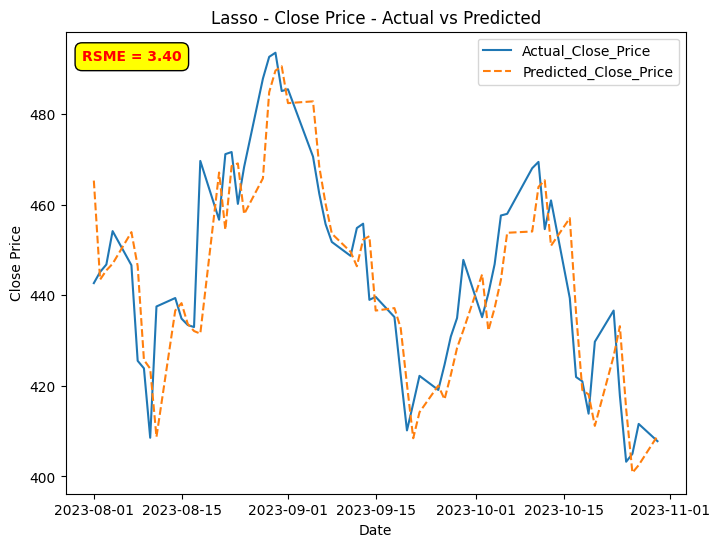

In [19]:
plt.figure(figsize=(8, 6))
plt.plot(y_test, label='Actual_Close_Price', linestyle='solid')
plt.plot(pd.Series(y_pred, index=y_test.index), label='Predicted_Close_Price', linestyle='dashed')
plt.title('Lasso - Close Price - Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.figtext(0.27, .85, f"RSME = {RMSE:.2f}", ha='right', va='top', color='red', weight='bold', bbox=dict(facecolor='yellow', edgecolor='black', boxstyle='round,pad=0.5'))
plt.show()

## Extreme Gradient Boosting (XGBoost) Regressors


In [20]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [21]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_test, label=y_test)

In [22]:
def objective(params):
    with mlflow.start_run():
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        MSE = mean_squared_error(y_test, y_pred, squared=False)
        RMSE = math.sqrt(MSE)
        mlflow.set_tag("model", "XGBoost")
        mlflow.log_metric("RMSE", RMSE)

    return {'loss': RMSE, 'status': STATUS_OK}

In [ ]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

In [27]:
best_run_id = runs = client.search_runs(
        experiment_ids=EXPERIMENT_ID,
        run_view_type=ViewType.ACTIVE_ONLY,
        max_results=1,
        order_by=["metrics.RMSE ASC"],
        filter_string="tags.model = 'XGBoost'"
    )[0].info.run_id

print(f"Best Run ID: {best_run_id}")
loaded_model = mlflow.pyfunc.load_model(f"runs:/{best_run_id}/model")
y_pred = loaded_model.predict(X_test)

MSE = mean_squared_error(y_test, y_pred, squared=False)
RMSE = math.sqrt(MSE)

print(f"XGBoost - RMSE: {RMSE}")

Best Run ID: 937796f04f3d4af890e0f97fe06dbdfc


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [00:41:29] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


XGBoost - RMSE: 4.035197491066294


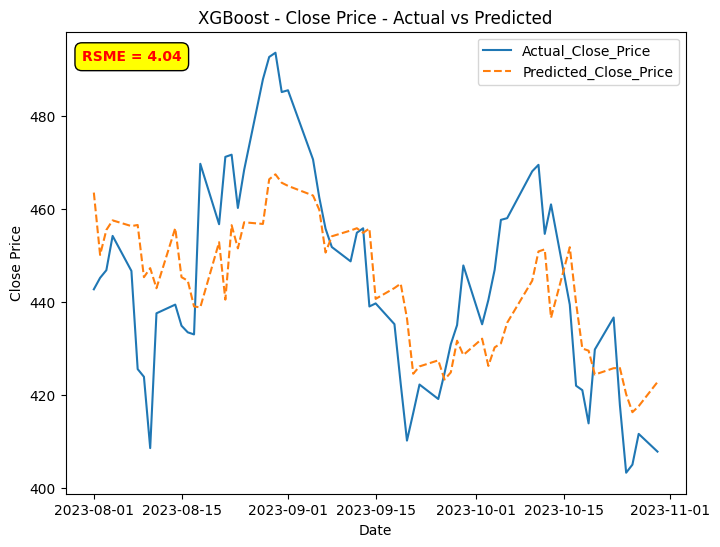

In [26]:
plt.figure(figsize=(8, 6))
plt.plot(y_test, label='Actual_Close_Price', linestyle='solid')
plt.plot(pd.Series(y_pred, index=y_test.index), label='Predicted_Close_Price', linestyle='dashed')
plt.title('XGBoost - Close Price - Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.figtext(0.27, .85, f"RSME = {RMSE:.2f}", ha='right', va='top', color='red', weight='bold', bbox=dict(facecolor='yellow', edgecolor='black', boxstyle='round,pad=0.5'))
plt.show()

# ---------XX---------------

## Trading Signals for Random Forest Model

In [ ]:
amount = 10000  # Initial Amount
signal = 0
Amount = []
balance = 0
action = []
portfolio = 0
Portfolio = []
stocks = 0
Stocks = []

for i in range(len(results) - 1):
    if results["Predicted"].iloc[i] > results["Actual"].iloc[i - 1]:
        action.append("Buy at Open & Sell at Close")
        stocks = int(amount / results["Open"].iloc[i])
        balance = int(amount % results["Close"].iloc[i])
        portfolio = stocks * results["Open"].iloc[i]
        print(i, "Buy at Open", round(portfolio, 2), stocks, round(balance, 2))

        portfolio = stocks * results["Close"].iloc[i]
        signal = 0
        stocks = 0
        amount = balance + portfolio
        portfolio = 0
        balance = 0
        print(i, "Sell at Close", round(amount, 2), balance)
        Amount.append(amount)
        Portfolio.append(round(portfolio, 5))

    else:
        action.append("Sell at Open & Buy at Close")
        stocks = int(amount / results["Open"].iloc[i])
        balance = int(amount % results["Close"].iloc[i])
        portfolio = stocks * results["Open"].iloc[i]
        print(i, "Sell at Open", round(portfolio, 2), "-", stocks, round(balance, 2))

        portfolio = stocks * results["Close"].iloc[i]
        signal = 0
        stocks = 0
        amount = balance + portfolio
        portfolio = 0
        balance = 0
        print(i, "Buy Back at Close", round(amount, 2), balance)
        Amount.append(amount)
        Portfolio.append(round(portfolio, 5))
    print("\n")

### Visualizing the above strategy

Initial_Investment : 10000$
Net Position: 7456.0 $


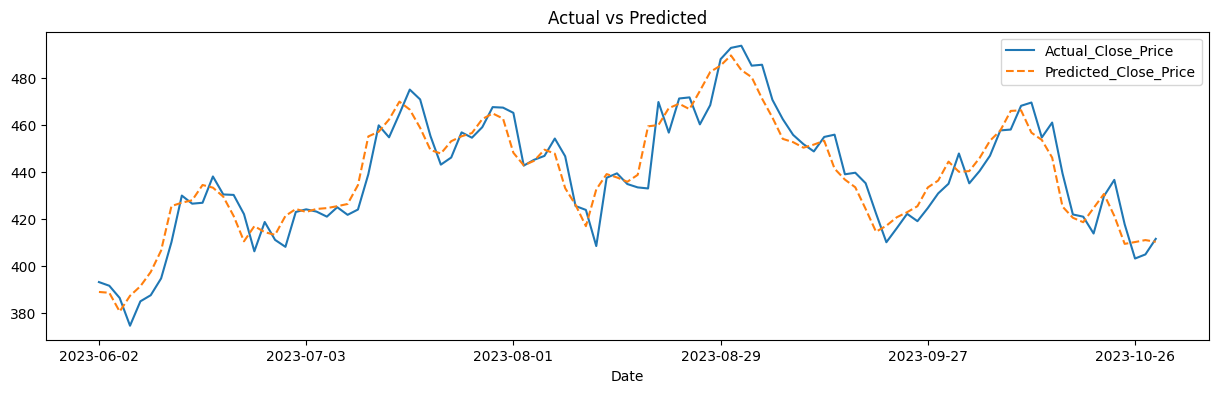

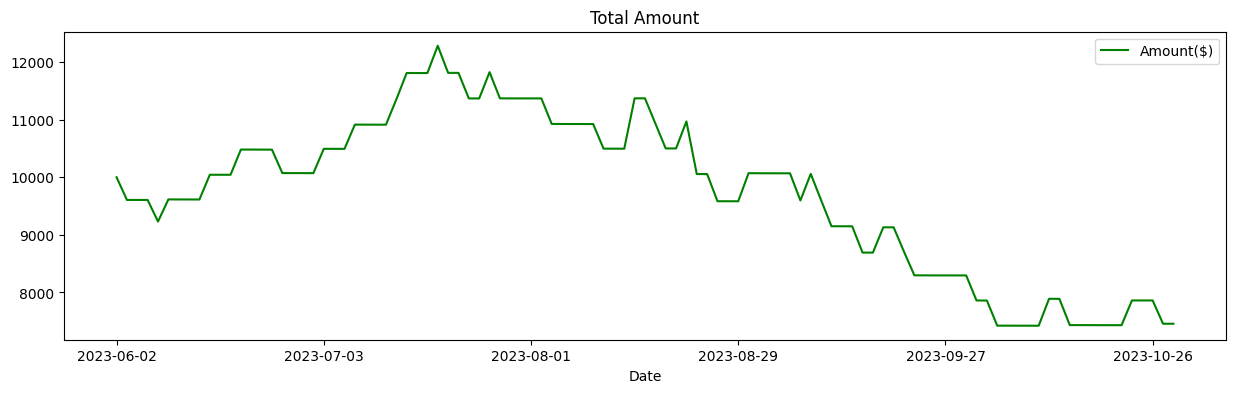

In [ ]:
Strategy_Result = pd.DataFrame(
    {
        "Actual_Close_Price": results.Close[1:],
        "Predicted_Close_Price": results.Predicted[1:],
        "Date": results.index[1:],
        "Amount($)": Amount,
    }
)

Strategy_Result[["Actual_Close_Price", "Predicted_Close_Price"]].plot(
    figsize=(15, 4), style=["-", "--"], title="Actual vs Predicted"
)


Strategy_Result[["Amount($)"]].plot(figsize=(15, 4), style=["-g"], title="Total Amount")

Profit = (Amount[-1]) / 10000
print("Initial_Investment : 10000$")
print("Net Position:", Amount[-1], "$")

In [ ]:
signal = 0
amount = 10000
Amount = []
balance = 0
action = []
portfolio = 0
Portfolio = []
stocks = 0
Stocks = []


for i in range(len(results) - 1):
    if results["Predicted"].iloc[i + 1] > results["Actual"].iloc[i]:
        if signal == 0:
            action.append("Buy")
            stocks = int(amount / results["Actual"].iloc[i])
            balance = int(amount % results["Actual"].iloc[i])
            portfolio = stocks * results["Actual"].iloc[i]
            signal = 1
            amount = portfolio + balance
            print(
                "Stock:",
                results["Actual"].iloc[i],
                "Action:",
                action[i],
                "Portfolio:",
                round(portfolio, 2),
                "Stocks:",
                stocks,
                "Balance_init:",
                balance,
                "total($)",
                round(amount, 2),
            )
            Portfolio.append(round(portfolio, 5))
            Amount.append(round(amount, 0))
            Stocks.append(stocks)
        else:
            action.append("Bought--Holding")
            portfolio = stocks * results["Actual"].iloc[i]
            amount = portfolio + balance
            print(
                "Stock:",
                results["Actual"].iloc[i],
                "Action:",
                action[i],
                "Portfolio:",
                round(portfolio, 2),
                "Stocks:",
                stocks,
                "Balance_init:",
                balance,
                "total($)",
                round(amount, 2),
            )
            Portfolio.append(round(portfolio, 5))
            Amount.append(round(amount, 0))
            Stocks.append(stocks)

    elif results["Predicted"].iloc[i + 1] < results["Actual"].iloc[i]:
        if signal == 1:
            action.append("Sell")
            portfolio = stocks * results["Actual"].iloc[i]

            signal = 0
            stocks = 0
            amount = balance + portfolio
            portfolio = 0
            balance = 0
            print(
                "Stock:",
                results["Actual"].iloc[i],
                "Action:",
                action[i],
                "Portfolio:",
                round(portfolio, 2),
                "Stocks:",
                stocks,
                "Balance_init:",
                balance,
                "total($)",
                round(amount, 2),
            )
            Portfolio.append(round(portfolio, 5))
            Amount.append(round(amount, 0))
            Stocks.append(stocks)
        else:
            action.append("Price-Prediction-Already-Lower")
            print(
                "Stock:",
                results["Actual"].iloc[i],
                "Action:",
                action[i],
                "Portfolio:",
                round(portfolio, 2),
                "Stocks:",
                stocks,
                "Balance_init:",
                balance,
                "total($)",
                round(amount, 2),
            )
            Portfolio.append(round(portfolio, 5))
            Amount.append(round(amount, 0))
            Stocks.append(stocks)

    print("\n")

In [ ]:
Strategy_Result = pd.DataFrame(
    {
        "Actual_Close_Price": results.Close[1:],
        "Predicted_Close_Price": results.Predicted[1:],
        "Date": results.index[1:],
        "Amount($)": Amount,
    }
)

Strategy_Result[["Actual_Close_Price", "Predicted_Close_Price"]].plot(
    figsize=(15, 4), style=["-", "--"], title="Actual vs Predicted"
)


Strategy_Result[["Amount($)"]].plot(figsize=(15, 4), style=["-g"], title="Total Amount")

Profit = (Amount[-1]) / 10000
print("Initial_Investment : 10000$")
print("Net Position:", Amount[-1], "$")

In [ ]:
Strategy_Result.head()

In [ ]:
# import matplotlib.pyplot as plt
# from matplotlib.animation import FuncAnimation

# # Assuming Strategy_Result is your DataFrame and it contains the 'Amount($)' column

# fig, ax = plt.subplots(figsize=(15, 4))

# def update(frame):
#     ax.clear()
#     ax.plot(Strategy_Result.index[:frame], Strategy_Result['Amount($)'][:frame], '-g')
#     ax.set_title('Total Amount')
#     ax.set_xlabel('Time')
#     ax.set_ylabel('Amount($)')

# # Assuming 'num_frames' is the number of frames for the animation
# num_frames = len(Strategy_Result)
# ani = FuncAnimation(fig, update, frames=num_frames, blit=False, repeat=False)

# ani.save('total_amount.gif', writer='pillow', fps=10)  # Save the animation as a GIF
# plt.show()

In [ ]:
Strategy_Result[["Actual_Close_Price", "Predicted_Close_Price"]]

### Plotting the Actual Price vs. Predicted Price

In [ ]:
plt.figure(figsize=(16, 8))
plt.title("Model")
plt.ylabel("Close Price (USD)", fontsize=18)
plt.plot(y)
plt.plot(predictions)
plt.legend(["Train", "Predictions"], loc="lower right")
plt.show()

## Feature Importance for Random Forest Model

In [ ]:
# Average feature importance
rf_feature_importance = pd.DataFrame(
    rf_model.feature_importances_, index=X.columns, columns=["feature importance"]
).sort_values("feature importance", ascending=False)

#### Plotting top 10 feature importance

<Axes: title={'center': 'Comparison for Feature Importance'}>

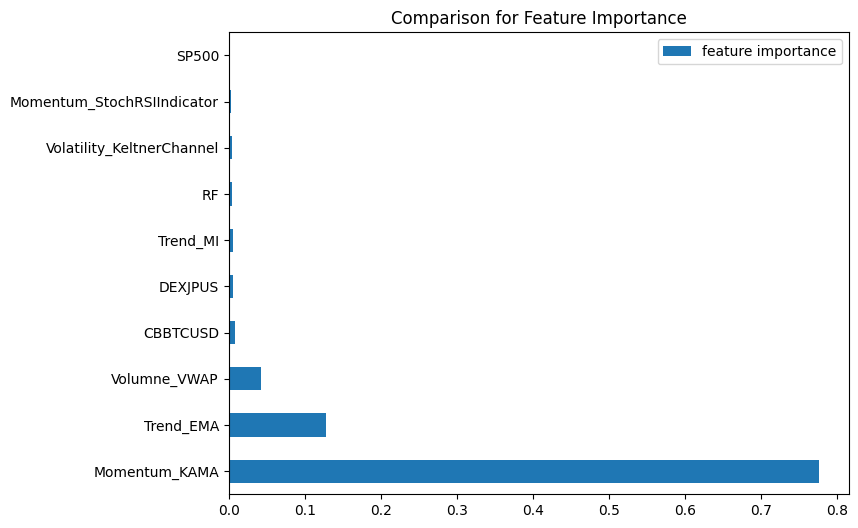

In [ ]:
rf_feature_importance[:10].plot(
    kind="barh", title="Comparison for Feature Importance", figsize=(8, 6)
)

In [ ]:
# All feature importance for each tree
rf_feature_all = pd.DataFrame(
    [tree.feature_importances_ for tree in rf_model.estimators_], columns=X.columns
)
rf_feature_all.head()

,Volume,Returns,Daily_Return,Typical_Price_Return,Volume_Log,Volume_Differencing,Volume_Differencing_10,Volumne_Percent_Change,MA_5,Volumne_MA_200,...,Volatility_KeltnerChannel,Mkt-RF,SMB,HML,RF,SP500,DEXJPUS,DEXUSEU,CBBTCUSD,ADS_Index
0,0.000056,0.000089,0.000244,0.000352,0.000023,0.000042,0.000242,0.000001,0.000090,5.043766e-05,...,1.029502e-03,0.000057,0.000289,0.000116,3.532957e-03,0.000001,0.004402,0.001036,0.078159,0.000218
1,0.000066,0.000006,0.000067,0.000008,0.000103,0.000008,0.000118,0.000161,0.000011,2.222572e-04,...,1.980229e-04,0.000166,0.000096,0.000802,0.000000e+00,0.000273,0.002793,0.004222,0.009606,0.009475
2,0.000162,0.000010,0.000013,0.000031,0.000056,0.000040,0.000005,0.000013,0.000260,5.373802e-05,...,7.752738e-05,0.000093,0.000014,0.000215,9.355762e-08,0.000314,0.005009,0.003437,0.010448,0.001530
3,0.000134,0.000017,0.000045,0.000000,0.000065,0.000055,0.000148,0.000081,0.000034,3.031659e-07,...,0.000000e+00,0.000116,0.000129,0.000304,1.035602e-06,0.000743,0.012670,0.001871,0.001625,0.000072
4,0.000009,0.000113,0.000033,0.000021,0.000036,0.000062,0.000105,0.000024,0.000177,1.273846e-04,...,7.779502e-08,0.000136,0.000387,0.000058,0.000000e+00,0.000629,0.004244,0.000276,0.011677,0.000253


In [ ]:
# Melted data i.e., long format
rf_feature_long = pd.melt(rf_feature_all, var_name="feature name", value_name="values")

## 2. XGBoost

In [ ]:
model = XGBRegressor(
    n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8
)
model.fit(X, y, eval_metric="rmse")
# Fit the model
predictions_xgboost = model.predict(X)
MSE = mean_squared_error(y, predictions_xgboost)
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:\n")
print(RMSE)
# Average feature importance
XGB_feature_importance = pd.DataFrame(
    model.feature_importances_, index=X.columns, columns=["feature importance"]
).sort_values("feature importance", ascending=False)

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


Root Mean Square Error:

0.00041256812252114876


### Feature Importance for XGBoost

<Axes: title={'center': 'Comparison for Feature Importance'}>

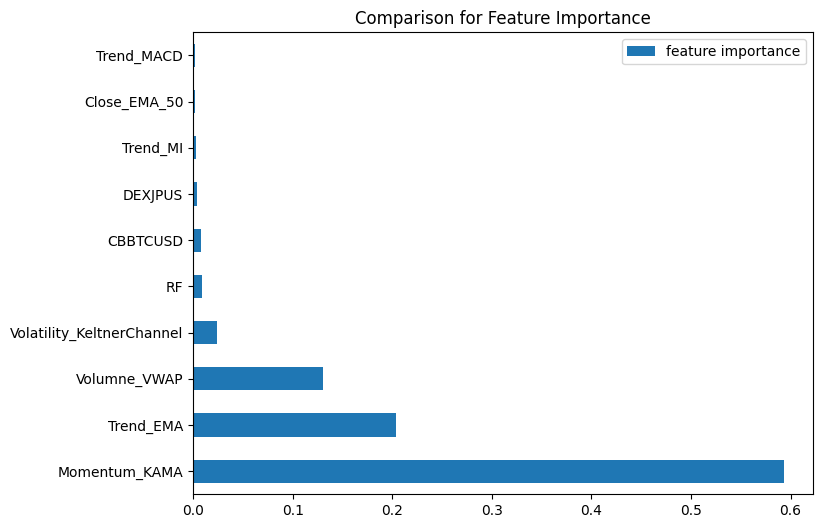

In [ ]:
XGB_feature_importance[:10].plot(
    kind="barh", title="Comparison for Feature Importance", figsize=(8, 6)
)

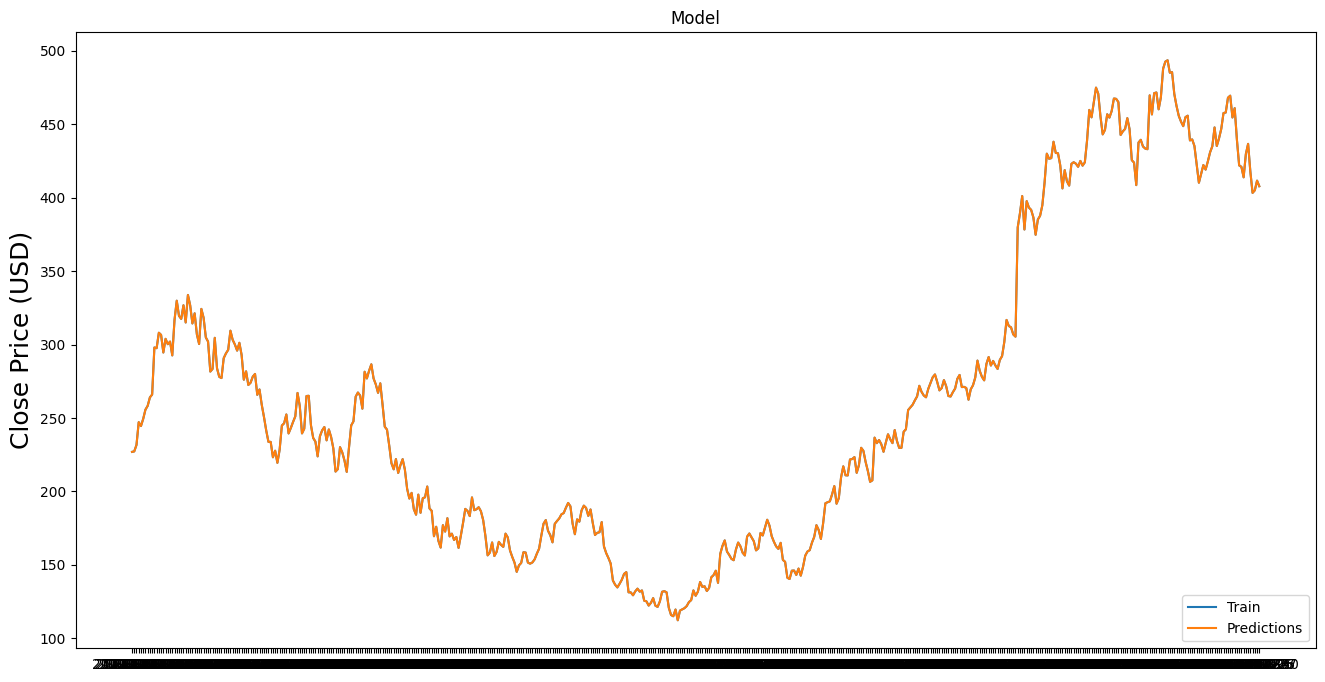

In [ ]:
plt.figure(figsize=(16, 8))
plt.title("Model")
plt.ylabel("Close Price (USD)", fontsize=18)
plt.plot(y)
plt.plot(predictions_xgboost)
plt.legend(["Train", "Predictions"], loc="lower right")
plt.show()

In [ ]:
predictions_xgboost[1:20]

array([227.26009, 231.65982, 247.17004, 244.50996, 249.41005, 255.67036,
       258.26968, 264.0106 , 265.98038, 298.00934, 297.52014, 308.04025,
       306.56955, 294.59058, 303.90012, 300.2502 , 302.02936, 292.6103 ,
       316.74997], dtype=float32)

## Trading Signals for XGBoost

0 Sell at Open 9622.25 - 25 57
0 Buy Back at Close 9999.5 0


1 Sell at Open 9623.28 - 24 167
1 Buy Back at Close 9605.48 0


2 Sell at Open 9338.16 - 24 204
2 Buy Back at Close 9605.04 0


3 Sell at Open 9319.2 - 24 328
3 Buy Back at Close 9604.96 0


4 Buy at Open 9339.6 24 236
4 Sell at Close 9230.0 0


5 Buy at Open 9053.76 24 372
5 Sell at Close 9614.4 0


6 Buy at Open 9368.88 24 309
6 Sell at Close 9613.8 0


7 Buy at Open 9408.0 24 138
7 Sell at Close 9613.68 0


8 Buy at Open 9242.78 23 178
8 Sell at Close 9613.06 0


9 Sell at Open 9389.52 - 23 153
9 Buy Back at Close 10042.31 0


10 Buy at Open 9798.46 23 232
10 Sell at Close 10042.19 0


11 Buy at Open 9993.5 23 223
11 Sell at Close 10042.16 0


12 Sell at Open 9889.54 - 23 404
12 Buy Back at Close 10479.84 0


13 Sell at Open 10440.24 - 24 149
13 Buy Back at Close 10479.8 0


14 Sell at Open 10140.72 - 24 153
14 Buy Back at Close 10479.0 0


15 Sell at Open 10191.36 - 24 348
15 Buy Back at Close 10478.16 0


16 Buy at Open

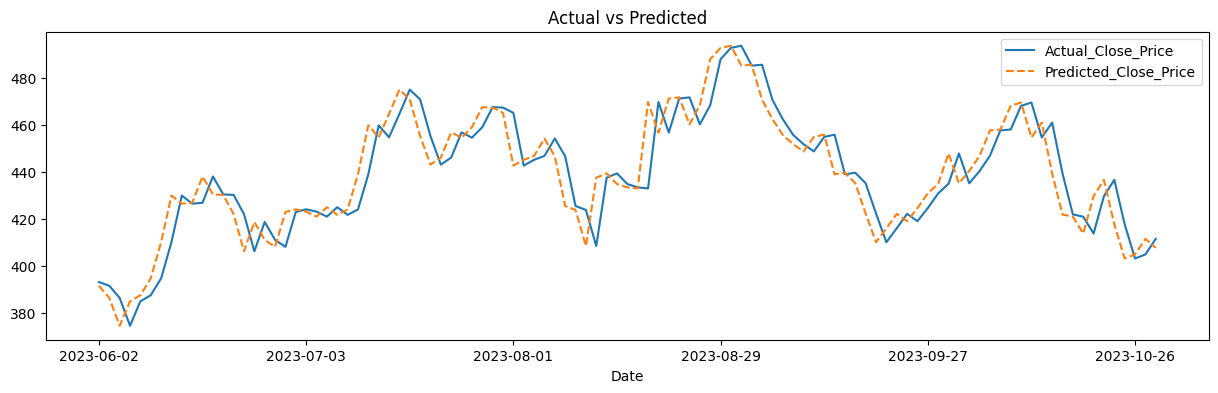

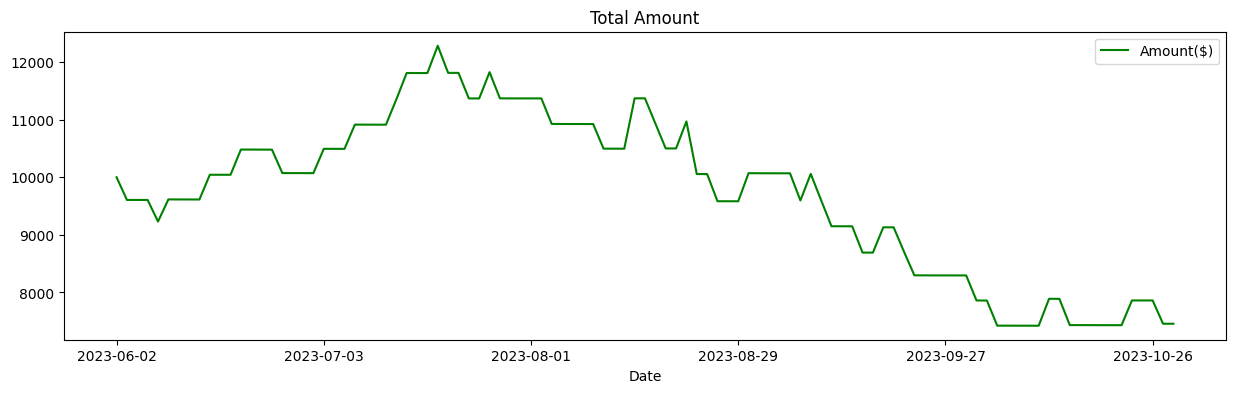

In [ ]:
results = pd.DataFrame(
    {
        "Actual": list(y),
        "Predicted": list(predictions_xgboost),
        "Date": nvda.index[:-1],
        "Open": nvda["Open"][:-1],
        "Close": nvda["Close"][:-1],
    }
)
results.set_index("Date", inplace=True)
results = results.loc["2023-06-01":"2023-11-31"]
results.head(10)
amount = 10000
signal = 0
Amount = []
balance = 0
action = []
portfolio = 0
Portfolio = []
stocks = 0
Stocks = []

for i in range(len(results) - 1):
    if results["Predicted"].iloc[i] > results["Actual"].iloc[i - 1]:
        action.append("Buy at Open & Sell at Close")
        stocks = int(amount / results["Open"].iloc[i])
        balance = int(amount % results["Close"].iloc[i])
        portfolio = stocks * results["Open"].iloc[i]
        print(i, "Buy at Open", round(portfolio, 2), stocks, round(balance, 2))

        # action.append('Sell at End')
        portfolio = stocks * results["Close"].iloc[i]
        signal = 0
        stocks = 0
        amount = balance + portfolio
        portfolio = 0
        balance = 0
        print(i, "Sell at Close", round(amount, 2), balance)
        Amount.append(amount)
        # add by Hongbo
        Portfolio.append(round(portfolio, 5))

    else:
        action.append("Sell at Open & Buy at Close")
        stocks = int(amount / results["Open"].iloc[i])
        balance = int(amount % results["Close"].iloc[i])
        portfolio = stocks * results["Open"].iloc[i]
        print(i, "Sell at Open", round(portfolio, 2), "-", stocks, round(balance, 2))

        # action.append('Buy at Close')
        portfolio = stocks * results["Close"].iloc[i]
        signal = 0
        stocks = 0
        amount = balance + portfolio
        portfolio = 0
        balance = 0
        print(i, "Buy Back at Close", round(amount, 2), balance)
        Amount.append(amount)
        # add by Hongbo
        Portfolio.append(round(portfolio, 5))
    print("\n")

Strategy_Result = pd.DataFrame(
    {
        "Actual_Close_Price": results.Close[1:],
        "Predicted_Close_Price": results.Predicted[1:],
        "Date": results.index[1:],
        "Amount($)": Amount,
    }
)

Strategy_Result[["Actual_Close_Price", "Predicted_Close_Price"]].plot(
    figsize=(15, 4), style=["-", "--"], title="Actual vs Predicted"
)


Strategy_Result[["Amount($)"]].plot(figsize=(15, 4), style=["-g"], title="Total Amount")

Profit = (Amount[-1]) / 10000
print("Initial_Investment : 10000$")
print("Net Position:", Amount[-1], "$")

## OLS Regression

                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     1465.
Date:                Tue, 12 Dec 2023   Prob (F-statistic):               0.00
Time:                        22:20:53   Log-Likelihood:                -1821.1
No. Observations:                 505   AIC:                             3732.
Df Residuals:                     460   BIC:                             3922.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

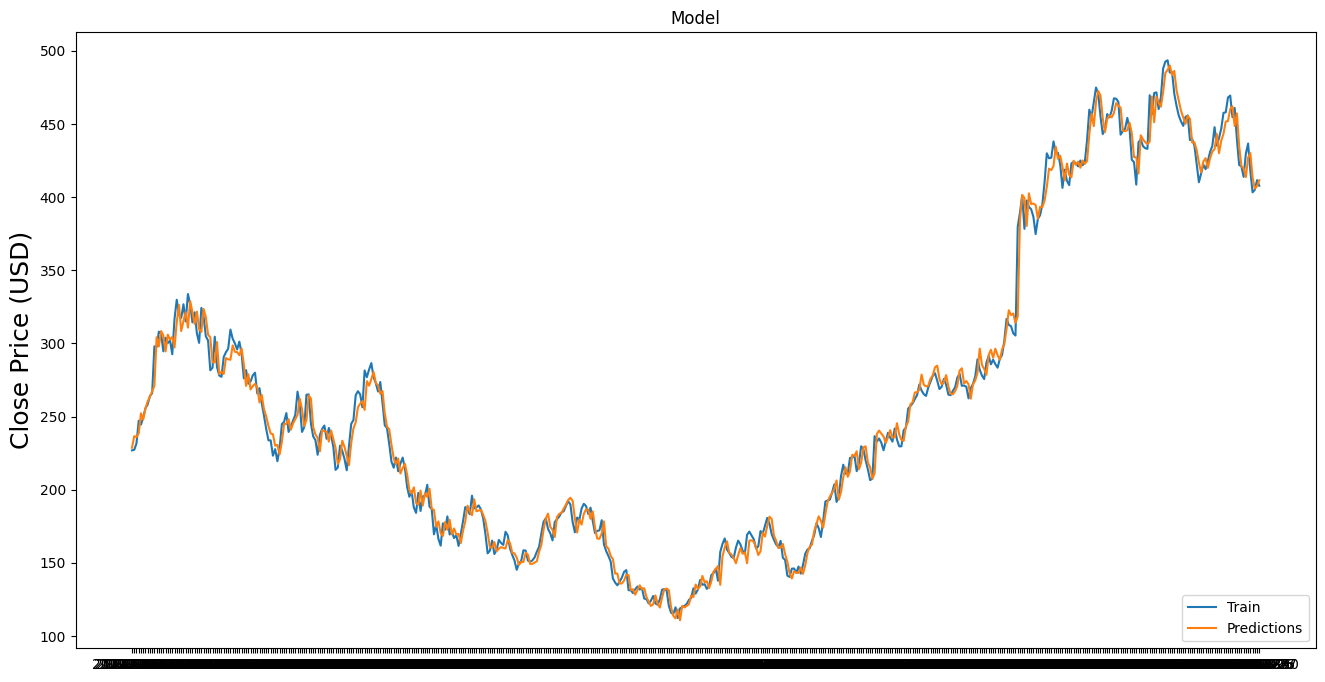

In [ ]:
x = sm.add_constant(X)
# Fitting the model
OLS_Model = sm.OLS(y, x).fit()
# Pring OLS results
print(OLS_Model.summary())
predictions_OLS = OLS_Model.predict(x)

# Plot the actual vs. prediction values
plt.figure(figsize=(16, 8))
plt.title("Model")
plt.ylabel("Close Price (USD)", fontsize=18)
plt.plot(y)
plt.plot(predictions_OLS)
plt.legend(["Train", "Predictions"], loc="lower right")
plt.show()

#### RMSE for OLS Regression model

In [ ]:
MSE = mean_squared_error(y, predictions_OLS)
RMSE = math.sqrt(MSE)

## Trading Signals for OLS Regression

Root Mean Square Error:

8.910316041180174
0 Sell at Open 9622.25 - 25 57
0 Buy Back at Close 9999.5 0


1 Buy at Open 9623.28 24 167
1 Sell at Close 9605.48 0


2 Buy at Open 9338.16 24 204
2 Sell at Close 9605.04 0


3 Buy at Open 9319.2 24 328
3 Sell at Close 9604.96 0


4 Buy at Open 9339.6 24 236
4 Sell at Close 9230.0 0


5 Buy at Open 9053.76 24 372
5 Sell at Close 9614.4 0


6 Buy at Open 9368.88 24 309
6 Sell at Close 9613.8 0


7 Buy at Open 9408.0 24 138
7 Sell at Close 9613.68 0


8 Sell at Open 9242.78 - 23 178
8 Buy Back at Close 9613.06 0


9 Sell at Open 9389.52 - 23 153
9 Buy Back at Close 10042.31 0


10 Sell at Open 9798.46 - 23 232
10 Buy Back at Close 10042.19 0


11 Sell at Open 9993.5 - 23 223
11 Buy Back at Close 10042.16 0


12 Sell at Open 9889.54 - 23 404
12 Buy Back at Close 10479.84 0


13 Sell at Open 10440.24 - 24 149
13 Buy Back at Close 10479.8 0


14 Sell at Open 10140.72 - 24 153
14 Buy Back at Close 10479.0 0


15 Sell at Open 10191.36 - 24 348
15 Bu

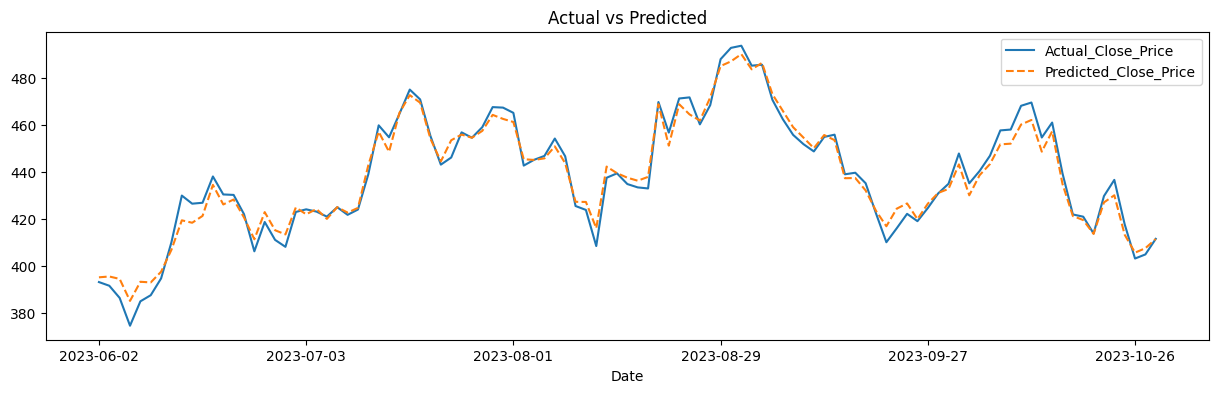

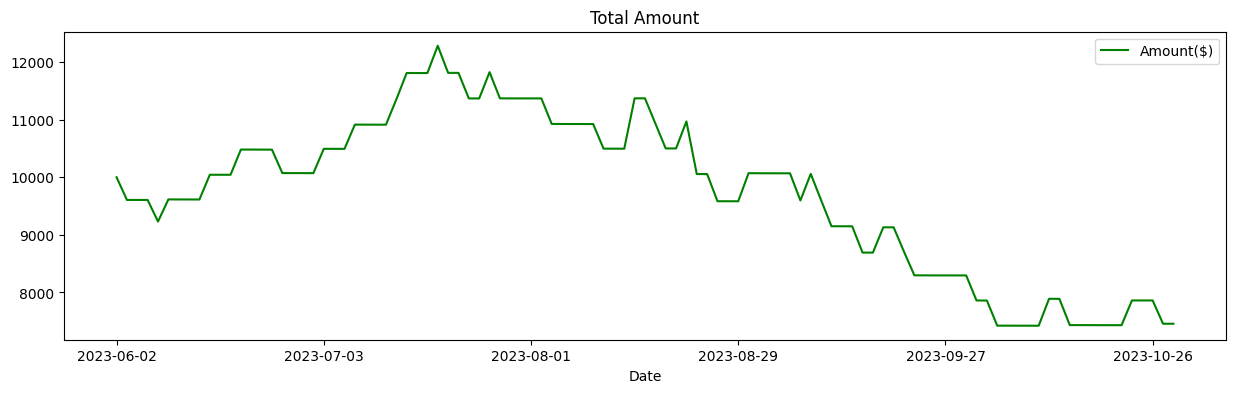

In [ ]:
MSE = mean_squared_error(y, predictions_OLS)
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:\n")
print(RMSE)
results = pd.DataFrame(
    {
        "Actual": list(y),
        "Predicted": list(predictions_OLS),
        "Date": nvda.index[:-1],
        "Open": nvda["Open"][:-1],
        "Close": nvda["Close"][:-1],
    }
)
results.set_index("Date", inplace=True)
results = results.loc["2023-06-01":"2023-11-31"]
results.head(10)
amount = 10000
signal = 0
Amount = []
balance = 0
action = []
portfolio = 0
Portfolio = []
stocks = 0
Stocks = []

for i in range(len(results) - 1):
    if results["Predicted"].iloc[i] > results["Actual"].iloc[i - 1]:
        action.append("Buy at Open & Sell at Close")
        stocks = int(amount / results["Open"].iloc[i])
        balance = int(amount % results["Close"].iloc[i])
        portfolio = stocks * results["Open"].iloc[i]
        print(i, "Buy at Open", round(portfolio, 2), stocks, round(balance, 2))

        # action.append('Sell at End')
        portfolio = stocks * results["Close"].iloc[i]
        signal = 0
        stocks = 0
        amount = balance + portfolio
        portfolio = 0
        balance = 0
        print(i, "Sell at Close", round(amount, 2), balance)
        Amount.append(amount)
        # add by Hongbo
        Portfolio.append(round(portfolio, 5))

    else:
        action.append("Sell at Open & Bull at Close")
        stocks = int(amount / results["Open"].iloc[i])
        balance = int(amount % results["Close"].iloc[i])
        portfolio = stocks * results["Open"].iloc[i]
        print(i, "Sell at Open", round(portfolio, 2), "-", stocks, round(balance, 2))

        # action.append('Buy at Close')
        portfolio = stocks * results["Close"].iloc[i]
        signal = 0
        stocks = 0
        amount = balance + portfolio
        portfolio = 0
        balance = 0
        print(i, "Buy Back at Close", round(amount, 2), balance)
        Amount.append(amount)
        # add by Hongbo
        Portfolio.append(round(portfolio, 5))
    print("\n")

Strategy_Result = pd.DataFrame(
    {
        "Actual_Close_Price": results.Close[1:],
        "Predicted_Close_Price": results.Predicted[1:],
        "Date": results.index[1:],
        "Amount($)": Amount,
    }
)

Strategy_Result[["Actual_Close_Price", "Predicted_Close_Price"]].plot(
    figsize=(15, 4), style=["-", "--"], title="Actual vs Predicted"
)


Strategy_Result[["Amount($)"]].plot(figsize=(15, 4), style=["-g"], title="Total Amount")

Profit = (Amount[-1]) / 10000
print("Initial_Investment : 10000$")
print("Net Position:", Amount[-1], "$")

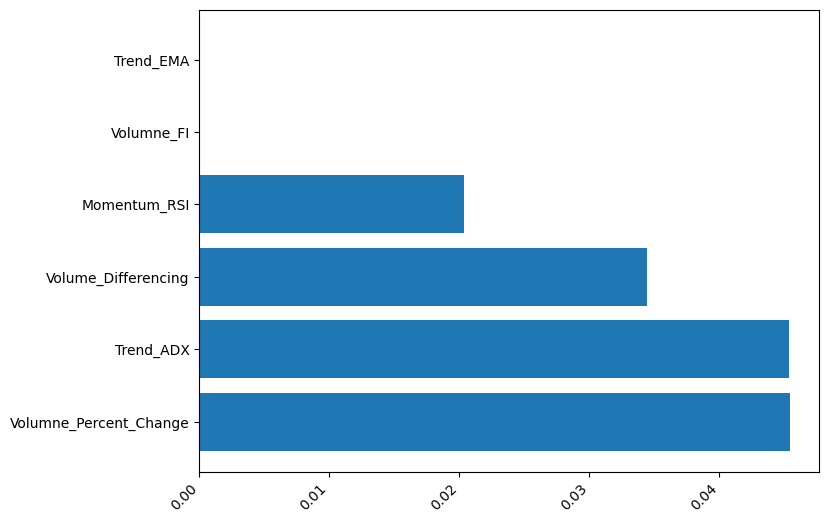

In [ ]:
data = pd.DataFrame(OLS_Model.pvalues).reset_index()
data.sort_values(0, inplace=True, ascending=False)

filtered_data = data[data[0] <= 0.05]

plt.figure(figsize=(8, 6))
plt.barh(filtered_data["index"], filtered_data[0])
plt.xticks(rotation=45, ha="right")
plt.show()

## 3. Other regression based models

### 3.1 Benchmark Model

In [ ]:
benchmark_prep = sm.OLS(y, X).fit()
benchmark_prep.summary()
benchmark_select = X.columns[np.abs(benchmark_prep.tvalues) >= 1.96]
benchmark = sm.OLS(y, X).fit()
print(benchmark.summary())
y_hat_benchmark1 = benchmark.predict(X)
corr_benchmark1 = ss.pearsonr(y_hat_benchmark1, y)[0]
print("Benchmark: corr (Y, Y_pred) = " + str(corr_benchmark1))
print(
    "Hard Thresholding Selected " + str(len(benchmark_select)) + " features: ",
    benchmark_select.values,
)
MSE = mean_squared_error(y, y_hat_benchmark1)
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:\n")
print(RMSE)

                                 OLS Regression Results                                
Dep. Variable:                  Close   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          1.044e+04
Date:                Tue, 12 Dec 2023   Prob (F-statistic):                        0.00
Time:                        22:20:58   Log-Likelihood:                         -1821.3
No. Observations:                 505   AIC:                                      3731.
Df Residuals:                     461   BIC:                                      3916.
Df Model:                          44                                                  
Covariance Type:            nonrobust                                                  
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------

### 3.2 Factor Selection using Ridge Regression

In [ ]:
a = 0.5
model2_prep = linear_model.Ridge(alpha=a, fit_intercept=False).fit(X, y)
model2_select = X.columns[np.abs(model2_prep.coef_) >= 0.001]
x = X[model2_select]
model2 = sm.OLS(y, x).fit()
print(model2.summary())
y_pred_model2 = model2.predict(x)
corr_model2 = ss.pearsonr(y_pred_model2, y)[0]
print("Model 1 - Ridge Regression: corr (Y, Y_pred) = " + str(corr_model2))
print(
    "Ridge Regression selected " + str(len(model2_select)) + " features: ",
    model2_select.values,
)
MSE = mean_squared_error(y, y_pred_model2)
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:\n")
print(RMSE)

                                 OLS Regression Results                                
Dep. Variable:                  Close   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          1.131e+04
Date:                Tue, 12 Dec 2023   Prob (F-statistic):                        0.00
Time:                        22:20:59   Log-Likelihood:                         -1834.3
No. Observations:                 505   AIC:                                      3747.
Df Residuals:                     466   BIC:                                      3911.
Df Model:                          39                                                  
Covariance Type:            nonrobust                                                  
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.71046e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


### 3.3 Factor Selection using LASSO

In [ ]:
a = 0.5
model3_prep = linear_model.Lasso(alpha=a, fit_intercept=False).fit(X, y)
model3_select = X.columns[np.abs(model3_prep.coef_) >= 0.001]
x = X
model3 = sm.OLS(y, x).fit()
print(model3.summary())
y_pred_model3 = model3.predict(x)
corr_model3 = ss.pearsonr(y_pred_model3, y)[0]
print("Model 2 - LASSO: corr (Y, Y_pred) = " + str(corr_model3))
print("LASSO selected " + str(len(model3_select)) + " features: ", model3_select.values)
MSE = mean_squared_error(y, y_pred_model3)
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:\n")
print(RMSE)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.169e+04, tolerance: 4.003e+03
  model = cd_fast.enet_coordinate_descent(


                                 OLS Regression Results                                
Dep. Variable:                  Close   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          1.044e+04
Date:                Tue, 12 Dec 2023   Prob (F-statistic):                        0.00
Time:                        22:20:59   Log-Likelihood:                         -1821.3
No. Observations:                 505   AIC:                                      3731.
Df Residuals:                     461   BIC:                                      3916.
Df Model:                          44                                                  
Covariance Type:            nonrobust                                                  
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------

### 3.4 Factor Selection using Least Angle Regression

In [ ]:
model1_prep = linear_model.Lars().fit(X, y)
model1_select = X.columns[model1_prep.coef_ != 0]
x = X[model1_select]
model1 = sm.OLS(y, x).fit()
print(model1.summary())
y_pred_model1 = model1.predict(x)
corr_model1 = ss.pearsonr(y_pred_model1, y)[0]
print("Model 3 - LARS: corr (Y, Y_pred) = " + str(corr_model1))
print(
    "LARS selected " + str(len(model1_select)) + " features: ",
    model1_select.values + ", ",
)
MSE = mean_squared_error(y, y_pred_model1)
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:\n")
print(RMSE)

                                 OLS Regression Results                                
Dep. Variable:                  Close   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          1.044e+04
Date:                Tue, 12 Dec 2023   Prob (F-statistic):                        0.00
Time:                        22:20:59   Log-Likelihood:                         -1821.3
No. Observations:                 505   AIC:                                      3731.
Df Residuals:                     461   BIC:                                      3916.
Df Model:                          44                                                  
Covariance Type:            nonrobust                                                  
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------

### 3.5 Factor Selection using Elastic Net

In [ ]:
a = 1.0
model4_prep = linear_model.ElasticNet(alpha=a, fit_intercept=False).fit(X, y)
model4_select = X.columns[np.abs(model4_prep.coef_) >= 0.001]
x = X[model4_select]
model4 = sm.OLS(y, x).fit()
print(model4.summary())
y_pred_model4 = model4.predict(x)
corr_model4 = ss.pearsonr(y_pred_model4, y)[0]
print("Model 4 - Elastic Net: corr (Y, Y_pred) = " + str(corr_model3))
print(
    "ElasticNet selected " + str(len(model4_select)) + " features: ",
    model4_select.values,
)
MSE = mean_squared_error(y, y_pred_model4)
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:\n")
print(RMSE)

                                 OLS Regression Results                                
Dep. Variable:                  Close   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          1.636e+04
Date:                Tue, 12 Dec 2023   Prob (F-statistic):                        0.00
Time:                        22:20:59   Log-Likelihood:                         -1840.4
No. Observations:                 505   AIC:                                      3735.
Df Residuals:                     478   BIC:                                      3849.
Df Model:                          27                                                  
Covariance Type:            nonrobust                                                  
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.266e+04, tolerance: 4.003e+03
  model = cd_fast.enet_coordinate_descent(
